# Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных
Данные находятся в файле `/datasets/autos.csv`.

<b> Признаки: </b>
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

<b>Целевой признак: </b>
- `Price` — цена (евро)

# Содержание

### [1 Подготовка данных](#1-bullet)
### [2 Обучение моделей](#2-bullet)
#### [2.1 LinearRegression](#2.1-bullet)
#### [2.2 XGBRegressor](#2.2-bullet)
#### [2.3 LGBMRegressor](#2.3-bullet)
#### [2.4 CatBoostRegressor](#2.3-bullet)
### [3 Анализ моделей на тестовой выборке](#4-bullet)


# 1. Подготовка данных <a class="anchor" id="1-bullet"></a>

Считаем данные в переменную `df`.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from math import sqrt
import matplotlib.pyplot as plt

import time
from datetime import timedelta

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Проверим наличие дубликатов в базе.

In [4]:
display(df[df.duplicated() == True])
df.duplicated().sum()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


4

Удалим дубликаты.

In [5]:
df.drop_duplicates(inplace=True)

Переведем название столбцов в нижний регистр.

In [6]:
df.columns = df.columns.str.lower()
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

Удалим столбцы, которые не оказывают влияние на стоимость авто:
- `datecrawled` - дата скачивания анкеты из базы,
- `datecreated` - дата создания объявления (т.к. там только 3 года),
- `numberofpictures` - количество фотографий автомобиля (там один нули),
- `lastseen` - дата последней активности пользователя.

In [7]:
for column in ['datecrawled', 'datecreated', 'numberofpictures', 'lastseen']:
    print(column)
    print(df[column].sort_values())
    print('***' * 20)

datecrawled
329497    2016-03-05 14:06:22
220583    2016-03-05 14:06:23
176823    2016-03-05 14:06:24
324763    2016-03-05 14:06:24
99885     2016-03-05 14:06:24
                 ...         
204218    2016-04-07 14:36:53
53739     2016-04-07 14:36:54
301030    2016-04-07 14:36:55
339649    2016-04-07 14:36:56
90713     2016-04-07 14:36:58
Name: datecrawled, Length: 354365, dtype: object
************************************************************
datecreated
61207     2014-03-10 00:00:00
4001      2015-03-20 00:00:00
342275    2015-06-18 00:00:00
86601     2015-08-07 00:00:00
175103    2015-08-10 00:00:00
                 ...         
184411    2016-04-07 00:00:00
262340    2016-04-07 00:00:00
214462    2016-04-07 00:00:00
241969    2016-04-07 00:00:00
260600    2016-04-07 00:00:00
Name: datecreated, Length: 354365, dtype: object
************************************************************
numberofpictures
0         0
236248    0
236247    0
236246    0
236245    0
         ..
118118 

In [8]:
df = df.drop(columns = ['datecrawled','numberofpictures', 'datecreated', 'lastseen'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 12 columns):
price                354365 non-null int64
vehicletype          316875 non-null object
registrationyear     354365 non-null int64
gearbox              334532 non-null object
power                354365 non-null int64
model                334660 non-null object
kilometer            354365 non-null int64
registrationmonth    354365 non-null int64
fueltype             321470 non-null object
brand                354365 non-null object
notrepaired          283211 non-null object
postalcode           354365 non-null int64
dtypes: int64(6), object(6)
memory usage: 35.1+ MB


Также удалим строки, где модель не указана, т.к. это один из самых выжных признаков.

In [9]:
df = df.loc[df['model'].notnull()]

In [10]:
df.shape

(334660, 12)

In [11]:
df.isnull().sum()

price                    0
vehicletype          30662
registrationyear         0
gearbox              15702
power                    0
model                    0
kilometer                0
registrationmonth        0
fueltype             25732
brand                    0
notrepaired          62100
postalcode               0
dtype: int64

In [12]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth,postalcode
count,334660.000000,334660.000000,334660.000000,334660.000000,334660.000000,334660.000000
mean,4504.372249,2003.924024,111.372659,128562.795076,5.806075,50671.327365
std,4531.457109,69.377633,185.157391,37205.638630,3.689157,25754.527341
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1150.000000,1999.000000,70.000000,125000.000000,3.000000,30419.000000
50%,2800.000000,2003.000000,105.000000,150000.000000,6.000000,49525.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,71229.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,99998.000000


Из сводной таблицы видим выбросы (нереальные значения) в признаках `power` и `registrationyear`. Изучим эти столбцы, а также другие из таблицы `df.describe()`.

price
26605         0
289191        0
82130         0
249834        0
82144         0
          ...  
215935    20000
24127     20000
61452     20000
280897    20000
113554    20000
Name: price, Length: 334660, dtype: int64


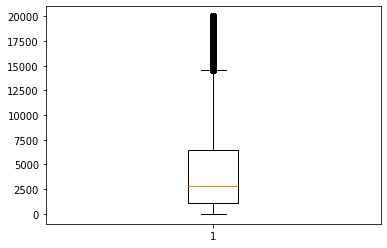

************************************************************
registrationyear
195144    1000
174893    1000
213499    1000
192705    1000
143621    1000
          ... 
326725    9999
174033    9999
217111    9999
28965     9999
227462    9999
Name: registrationyear, Length: 334660, dtype: int64


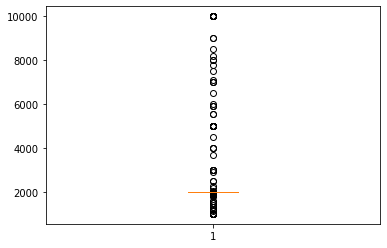

************************************************************
power
0             0
30536         0
261918        0
30538         0
261920        0
          ...  
63986     17932
132485    19208
114106    19211
299180    19312
219584    20000
Name: power, Length: 334660, dtype: int64


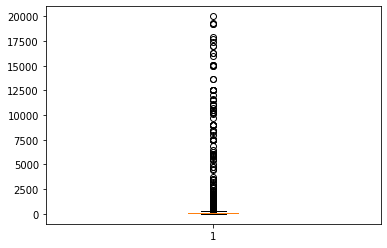

************************************************************
kilometer
133079      5000
299914      5000
81516       5000
7107        5000
299925      5000
           ...  
141454    150000
141456    150000
141457    150000
141461    150000
354368    150000
Name: kilometer, Length: 334660, dtype: int64


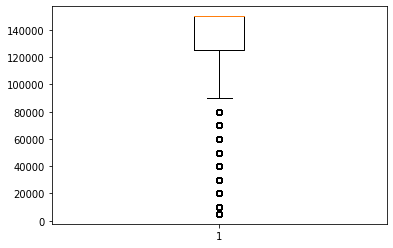

************************************************************
registrationmonth
0          0
80719      0
281768     0
80729      0
80742      0
          ..
155466    12
155464    12
33493     12
116065    12
124225    12
Name: registrationmonth, Length: 334660, dtype: int64


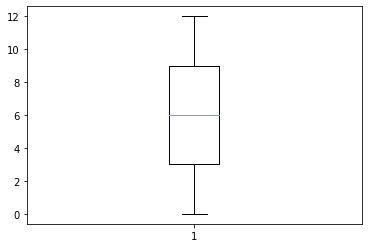

************************************************************
postalcode
179311     1067
79907      1067
210377     1067
264645     1067
80334      1067
          ...  
275522    99998
255284    99998
251550    99998
233207    99998
284919    99998
Name: postalcode, Length: 334660, dtype: int64


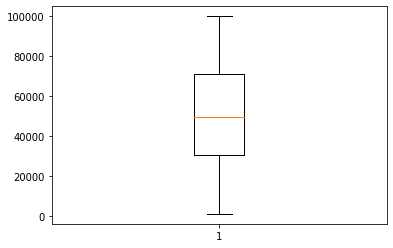

************************************************************


In [13]:
for column in ['price','registrationyear', 'power', 'kilometer', 'registrationmonth', 'postalcode']:
    print(column)
    print(df[column].sort_values())
    plt.boxplot(df[column])
    plt.show()
    print('***' * 20)

Замечаем, что столбец `kilometer` имеет дискретные значения, его фильтровать не будем.

In [14]:
# напишем функцию для удаления выбросов в "количественных" столбцах
def operating_values(df, column):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    column_cleanest = df.loc[(df[column] > (q1 - 1.5*iqr)) & (df[column] < (q3 + 1.5*iqr))]
    return column_cleanest

In [15]:
for column in ['power', 'registrationyear']:
    df = operating_values(df, column)

Там, где мощность `power` = 0 и месяц `registrationmonth` равен 0 заменим на значение `Nan`.

In [16]:
df['power'].loc[df['power'] == 0] = 'Nan'
df['registrationmonth'].loc[df['registrationmonth'] == 0] = 'Nan'

In [17]:
df.describe()

,price,registrationyear,kilometer,postalcode
count,323031.000000,323031.000000,323031.000000,323031.000000
mean,4359.543434,2003.592977,128937.733530,50646.899028
std,4404.377851,6.289781,36793.806689,25740.472003
min,0.000000,1986.000000,5000.000000,1067.000000
25%,1100.000000,1999.000000,125000.000000,30419.000000
50%,2750.000000,2003.000000,150000.000000,49509.000000
75%,6250.000000,2008.000000,150000.000000,71131.000000
max,20000.000000,2019.000000,150000.000000,99998.000000


Отдельно изучим колонку `price`.

Text(0, 0.5, 'Цена автомобиля, евро')

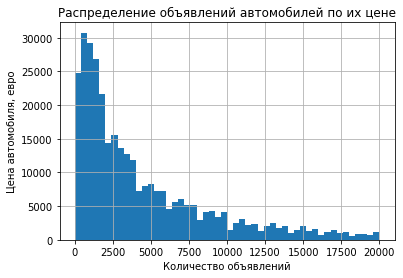

In [18]:
df['price'].hist(bins = 50)
plt.title('Распределение объявлений автомобилей по их цене')
plt.xlabel('Количество объявлений')
plt.ylabel('Цена автомобиля, евро')

Т.к. неизвестно про условия владения автомобилем в странах Европы (или там, откуда получены данные), то из разумных соображений удалим все данные, где стоимость авто меньше 100 евро.

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8364502410>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8364e59690>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8364640d90>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8364e595d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8364e49610>],
 'means': []}

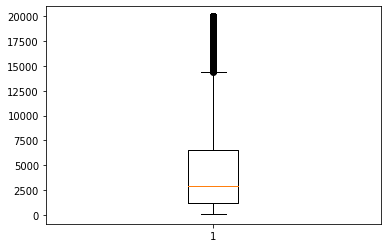

In [19]:
df = df.loc[df['price'] >= 100]
plt.boxplot(df['price'])

In [20]:
# Посмотрим на выбросы, где стоимость авто больше 15 000 евро.
df[df['price'] > 15000]

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,postalcode
14,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no,4177
33,18000,sedan,2007,auto,218,3er,20000,5,petrol,bmw,no,39179
179,16449,wagon,2015,auto,110,fabia,10000,8,petrol,skoda,no,95502
236,15700,sedan,2011,manual,170,golf,90000,3,gasoline,volkswagen,no,32832
282,18700,coupe,2009,auto,213,mustang,80000,8,petrol,ford,no,97424
...,...,...,...,...,...,...,...,...,...,...,...,...
354180,15800,convertible,2002,manual,197,clk,90000,1,petrol,mercedes_benz,no,96269
354187,15190,bus,2011,manual,140,touran,80000,6,petrol,volkswagen,no,49835
354210,17990,bus,2007,auto,174,transporter,125000,7,gasoline,volkswagen,no,93453
354279,16500,suv,2013,manual,116,i_reihe,30000,9,gasoline,hyundai,no,76297


Если исходить из российских реалий, то стоимоcть многих из этих авто вполне можеть быть больше 15 000 евро. Поэтому эти выбросы по признаку `price` оставляем без изменений.

In [21]:
for column in ['gearbox', 'fueltype', 'notrepaired']:
    print(column)
    print(df[column].value_counts())
    print('***' * 20)

gearbox
manual    244212
auto       55987
Name: gearbox, dtype: int64
************************************************************
fueltype
petrol      193021
gasoline     92965
lpg           4367
cng            524
hybrid         203
other           88
electric        61
Name: fueltype, dtype: int64
************************************************************
notrepaired
no     227400
yes     30511
Name: notrepaired, dtype: int64
************************************************************


Предположу, что `petrol` и `gasoline` это одинаковое название, поэтому переименуем `gasoline` в `petrol`.

In [22]:
df['fueltype'].loc[df['fueltype'] == 'gasoline'] = 'petrol'

In [23]:
print(df['fueltype'].value_counts())

petrol      285986
lpg           4367
cng            524
hybrid         203
other           88
electric        61
Name: fueltype, dtype: int64


Заменим на `Nan` все пропуски.

In [24]:
df = df.fillna('Nan')

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313040 entries, 0 to 354368
Data columns (total 12 columns):
price                313040 non-null int64
vehicletype          313040 non-null object
registrationyear     313040 non-null int64
gearbox              313040 non-null object
power                313040 non-null object
model                313040 non-null object
kilometer            313040 non-null int64
registrationmonth    313040 non-null object
fueltype             313040 non-null object
brand                313040 non-null object
notrepaired          313040 non-null object
postalcode           313040 non-null int64
dtypes: int64(4), object(8)
memory usage: 31.0+ MB


In [26]:
df.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,postalcode
0,480,Nan,1993,manual,Nan,golf,150000,Nan,petrol,volkswagen,Nan,70435
2,9800,suv,2004,auto,163,grand,125000,8,petrol,jeep,Nan,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,petrol,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775


In [27]:
df_with_cat = df.copy(deep='true')

# 2 Обучение моделей <a class="anchor" id="2-bullet"></a>

In [28]:
df = pd.get_dummies(df, drop_first=True)

Категориальные признаки закодируем их с помощью `get_dummies`.

Разделим данные на выборки в соотношении :

- `train` - обучающую (60% данных),
- `valid` - валидационную (20% данных),
- `test` - тестовую (20% данных).

In [29]:
target = df['price']
features = df.drop('price', axis=1)

In [30]:
# разделим данные features и target на две части (train и test) в соотношении 60% к 40% 
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

In [31]:
# разделим данные features_test и target_test на две части (test и valid) в соотношении 50% к 50% 
features_test, features_valid, target_test, target_valid = train_test_split(
    features_test, target_test, test_size=0.5, random_state=12345)

In [32]:
print(features_test.shape, features_valid.shape, features_train.shape)

(62608, 569) (62608, 569) (187824, 569)


Обучим следующие модели:
- LinearRegression
- LGBMRegressor
- LGBMRegressor
- CatBoostRegressor

и выберем оптимальную по следующим параметрам:

- качество предсказания (параметр <b>rmse</b>)
- скорость предсказания
- время обучения

### 2.1 LinearRegression <a class="anchor" id="2.1-bullet"></a>

In [33]:
%%time

model = LinearRegression()

start_time = time.monotonic()
model.fit(features_train,target_train)
end_time = time.monotonic()

time_fit = timedelta(seconds=end_time - start_time)
        
start_time = time.monotonic()
predictions = model.predict(features_valid)
end_time = time.monotonic()

time_predict = timedelta(seconds=end_time - start_time)

mse = mean_squared_error(target_valid, predictions)
rmse = sqrt(mse)

print('Результат rmse = ', rmse)
print('Время обучения модели c такими параметрами =', time_fit)
print('Время предсказания для модели c такими параметрами =', time_predict)

print('_ _ _ '*20)

Результат rmse =  2279.7746909109273
Время обучения модели c такими параметрами = 0:00:57.089831
Время предсказания для модели c такими параметрами = 0:00:00.330953
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
CPU times: user 33.9 s, sys: 23.5 s, total: 57.4 s
Wall time: 57.5 s


### 2.2 XGBRegressor <a class="anchor" id="2.2-bullet"></a>

In [34]:
#%%time
#best_result = 100000

#for depth in range(5,15,3): 
    
#    for n_estimators in range(10,60,20):
        
#        model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth  = depth, verbosity = 0, random_state=12345)

#        start_time = time.monotonic()
#        model.fit(features_train,target_train)
#        end_time = time.monotonic()
        
#        time_fit = timedelta(seconds=end_time - start_time)
        
#        start_time = time.monotonic()
#        predictions = model.predict(features_valid)
#        end_time = time.monotonic()
        
#        time_predict = timedelta(seconds=end_time - start_time)
        
#        mse = mean_squared_error(target_valid, predictions)
#        rmse = sqrt(mse)
        
#        print(rmse, time_fit, time_predict)
        
#        if best_result > rmse:
#            best_result = rmse
#            best_depth = depth
#            best_n_estimators = n_estimators
#            best_time_fit = time_fit
#            best_time_predict = time_predict
            
#print('*' * 50)
#print()

#print('Лучший результат rmse =', best_result, 'при max_depth  = ', best_depth, 'и при n_estimators = ', best_n_estimators)
#print('Время обучения модели c такими параметрами =', best_time_fit)
#print('Время предсказания для модели c такими параметрами =', best_time_predict)

#print('_ _ _ '*20)

### 2.3  LGBMRegressor <a class="anchor" id="2.3-bullet"></a>

Для копии датасета `df_with_cat` проделаем всё то, что делали для базы данных df.

In [35]:
for i in ['vehicletype', 'gearbox', 'power', 'model', 'fueltype', 'brand', 'notrepaired','registrationmonth']:
    df_with_cat[i] = df_with_cat[i].astype('category')

In [36]:
target_with_cat = df_with_cat['price']
features_with_cat = df_with_cat.drop('price', axis=1)

In [37]:
# разделим данные features и target на две части (train и test) в соотношении 60% к 40% 
features_train_with_cat, features_test_with_cat, target_train_with_cat, target_test_with_cat = train_test_split(
    features_with_cat, target_with_cat, test_size=0.4, random_state=12345)

In [38]:
# разделим данные features_test и target_test на две части (test и valid) в соотношении 50% к 50% 
features_test_with_cat, features_valid_with_cat, target_test_with_cat, target_valid_with_cat = train_test_split(
    features_test_with_cat, target_test_with_cat, test_size=0.5, random_state=12345)

In [39]:
print(features_test_with_cat.shape, features_valid_with_cat.shape, features_train_with_cat.shape)

(62608, 11) (62608, 11) (187824, 11)


In [40]:
%%time
best_result = 100000

for boosting_type in ['gbdt','dart','goss']: 
    
    for n_estimators in range(10,91,40):
        
        model = lgb.LGBMRegressor(n_estimators = n_estimators, boosting_type = boosting_type, random_state=12345)

        start_time = time.monotonic()
        model.fit(features_train_with_cat,target_train_with_cat)
        end_time = time.monotonic()
        
        time_fit = timedelta(seconds=end_time - start_time)

        start_time = time.monotonic()
        predictions = model.predict(features_valid_with_cat)
        end_time = time.monotonic()
        
        time_predict = timedelta(seconds=end_time - start_time)
        
        mse = mean_squared_error(target_valid_with_cat, predictions)
        rmse = sqrt(mse)
        
        print(rmse, time_fit, time_predict)
        
        if best_result > rmse:
            best_result = rmse
            best_boosting_type = boosting_type
            best_n_estimators = n_estimators
            best_time_fit = time_fit
            best_time_predict = time_predict
            
print('*' * 50)
print()

print('Лучший результат rmse =', best_result, 'при boosting_type = ', best_boosting_type, 'и при n_estimators = ', best_n_estimators)
print('Время обучения модели c такими параметрами =', best_time_fit)
print('Время предсказания для модели c такими параметрами =', best_time_predict)

print('_ _ _ '*20)

2434.438181448264 0:00:10.574834 0:00:00.209321
1581.1528023512317 0:01:32.090670 0:00:00.497049
1528.135009994364 0:00:55.998288 0:00:00.926374
2689.343665748685 0:00:12.096419 0:00:00.185757
2070.3971762383135 0:01:23.096915 0:00:00.520644
1748.3597373860778 0:06:42.072781 0:00:00.818732
2434.438181448264 0:00:47.084070 0:00:00.197672
1.0986606267627404e+21 0:02:39.896551 0:00:00.325416
5.7910934087838225e+22 0:03:11.618146 0:00:00.698087
**************************************************

Лучший результат rmse = 1528.135009994364 при boosting_type =  gbdt и при n_estimators =  90
Время обучения модели c такими параметрами = 0:00:55.998288
Время предсказания для модели c такими параметрами = 0:00:00.926374
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
CPU times: user 17min 24s, sys: 7.38 s, total: 17min 32s
Wall time: 17min 38s


### 2.4 CatBoostRegressor <a class="anchor" id="2.4-bullet"></a>

In [41]:
%%time
best_result = 100000

for iterations in range(1,202,50): 
    
    for depth in range(1,16,4):
        
        model = CatBoostRegressor(iterations = iterations, learning_rate = 0.1, depth = depth, random_state=12345, cat_features = ['vehicletype', 'gearbox', 'power', 'model', 'fueltype', 'brand', 'notrepaired','registrationmonth'])
        
        start_time = time.monotonic()
        model.fit(features_train_with_cat,target_train_with_cat)
        end_time = time.monotonic()
        
        time_fit = timedelta(seconds=end_time - start_time)
        
        start_time = time.monotonic()
        predictions = model.predict(features_valid_with_cat)
        end_time = time.monotonic()
        
        time_predict = timedelta(seconds=end_time - start_time)
        
        mse = mean_squared_error(target_valid_with_cat, predictions)
        rmse = sqrt(mse)
        
        print(rmse, time_fit, time_predict)
        
        if best_result > rmse:
            best_result = rmse
            best_depth = depth
            best_iterations = iterations
            best_time_fit = time_fit
            best_time_predict = time_predict
            
print('*' * 50)
print()

print('Лучший результат rmse =', best_result, 'при depth = ', best_depth, 'и при iterations = ', best_iterations)
print('Время обучения модели c такими параметрами =', best_time_fit)
print('Время предсказания для модели c такими параметрами =', best_time_predict)

print('_ _ _ '*20)

0:	learn: 4250.1872914	total: 103ms	remaining: 0us
4258.455268429584 0:00:02.361553 0:00:00.094590
0:	learn: 4140.7038737	total: 316ms	remaining: 0us
4149.622966858582 0:00:02.388937 0:00:00.082167
0:	learn: 4110.1991441	total: 582ms	remaining: 0us
4119.113013332856 0:00:02.544265 0:00:00.105858
0:	learn: 4102.5531329	total: 1.2s	remaining: 0us
4111.6709774809915 0:00:03.190303 0:00:00.103781
0:	learn: 4250.1872914	total: 42.5ms	remaining: 2.12s
1:	learn: 4127.1973410	total: 231ms	remaining: 5.66s
2:	learn: 4022.5245377	total: 335ms	remaining: 5.35s
3:	learn: 3935.4153739	total: 523ms	remaining: 6.14s
4:	learn: 3859.0964901	total: 621ms	remaining: 5.72s
5:	learn: 3793.8619238	total: 724ms	remaining: 5.43s
6:	learn: 3738.4787927	total: 833ms	remaining: 5.23s
7:	learn: 3691.3423142	total: 938ms	remaining: 5.04s
8:	learn: 3606.6305151	total: 1.12s	remaining: 5.22s
9:	learn: 3536.9226297	total: 1.22s	remaining: 5s
10:	learn: 3477.1239646	total: 1.33s	remaining: 4.84s
11:	learn: 3425.631268

По совокупности затраченного времени на обучение и предсказание остановимся на:
    
- <b>CatBoostRegressor</b>
- <b>rmse</b> = 1587.447544668118 
- <b>depth</b> =  13
- <b>iterations</b> =  201
- <b>Время обучения модели c такими параметрами</b> = 1 минут 54.088908 секунд
- <b>Время предсказания для модели c такими параметрами</b> = 0 минут 00.217145 секунд

# 3. Анализ моделей на тестовой выборке <a class="anchor" id="4-bullet"></a>

In [43]:
# создадим пустые массивы для построения сравнительной таблицы
column_rmse = []
column_time_fit = []
column_time_predict = []

Запуск `LinearRegression` на тестовой выборке.

In [44]:
model = LinearRegression()

start_time = time.monotonic()
model.fit(features_train,target_train)
end_time = time.monotonic()

time_fit = timedelta(seconds=end_time - start_time)
        
start_time = time.monotonic()
predictions = model.predict(features_test)
end_time = time.monotonic()

time_predict = timedelta(seconds=end_time - start_time)

mse = mean_squared_error(target_test, predictions)
rmse = sqrt(mse)

column_rmse.append(rmse)
column_time_fit.append(time_fit)
column_time_predict.append(time_predict)

Запуск `LGBMRegressor` на тестовой выборке с лучшими параметрами из предыдущего шага.

In [45]:
model = lgb.LGBMRegressor(n_estimators = 90, boosting_type = 'gbdt', random_state=12345)

start_time = time.monotonic()
model.fit(features_train_with_cat,target_train_with_cat)
end_time = time.monotonic()
        
time_fit = timedelta(seconds=end_time - start_time)

start_time = time.monotonic()
predictions = model.predict(features_test_with_cat)
end_time = time.monotonic()
        
time_predict = timedelta(seconds=end_time - start_time)
        
mse = mean_squared_error(target_test_with_cat, predictions)
rmse = sqrt(mse)

column_rmse.append(rmse)
column_time_fit.append(time_fit)
column_time_predict.append(time_predict)

Запуск `CatBoostRegressor` на тестовой выборке с лучшими параметрами из предыдущего шага.

In [46]:
model = CatBoostRegressor(iterations = 201, learning_rate = 0.1, depth = 13, random_state=12345, cat_features = ['vehicletype', 'gearbox', 'power', 'model', 'fueltype', 'brand', 'notrepaired', 'registrationmonth'])
        
start_time = time.monotonic()
model.fit(features_train_with_cat,target_train_with_cat)
end_time = time.monotonic()
        
time_fit = timedelta(seconds=end_time - start_time)
        
start_time = time.monotonic()
predictions = model.predict(features_test_with_cat)
end_time = time.monotonic()
        
time_predict = timedelta(seconds=end_time - start_time)
        
mse = mean_squared_error(target_test_with_cat, predictions)
rmse = sqrt(mse)

column_rmse.append(rmse)
column_time_fit.append(time_fit)
column_time_predict.append(time_predict)

0:	learn: 4078.1631805	total: 3.09s	remaining: 10m 17s
1:	learn: 3795.8602219	total: 6s	remaining: 9m 56s
2:	learn: 3547.7808459	total: 8.81s	remaining: 9m 41s
3:	learn: 3329.8967443	total: 11.6s	remaining: 9m 31s
4:	learn: 3138.6830863	total: 14.6s	remaining: 9m 31s
5:	learn: 2957.8086333	total: 17.4s	remaining: 9m 25s
6:	learn: 2799.0308097	total: 20.7s	remaining: 9m 33s
7:	learn: 2657.0258853	total: 23.8s	remaining: 9m 34s
8:	learn: 2534.9944141	total: 26.8s	remaining: 9m 31s
9:	learn: 2430.1586501	total: 29.6s	remaining: 9m 25s
10:	learn: 2334.3444779	total: 32.5s	remaining: 9m 21s
11:	learn: 2246.8434509	total: 35.4s	remaining: 9m 17s
12:	learn: 2171.9610268	total: 38s	remaining: 9m 9s
13:	learn: 2105.5915539	total: 40.5s	remaining: 9m 1s
14:	learn: 2047.2225078	total: 43.4s	remaining: 8m 58s
15:	learn: 1996.8124818	total: 46s	remaining: 8m 51s
16:	learn: 1954.3687370	total: 48.7s	remaining: 8m 46s
17:	learn: 1915.4469823	total: 52.2s	remaining: 8m 50s
18:	learn: 1879.9658228	tota

In [47]:
df_info = pd.DataFrame(np.array([column_rmse, column_time_fit, column_time_predict]),
                   columns=['LinearRegression', 'LGBMRegressor', 'CatBoostRegressor'], index=['rmse', 'time_fit', 'time_predict'])

In [48]:
df_info

,LinearRegression,LGBMRegressor,CatBoostRegressor
rmse,2277.37,1542.5,1505.92
time_fit,0:01:00.447234,0:02:00.693225,0:11:44.345974
time_predict,0:00:00.400399,0:00:00.931062,0:00:00.872611


После сравнения моделей на тестовой выборке выбираем:

- <b>CatBoostRegressor</b>
- <b>rmse</b> = 1505.92
- <b>Время обучения модели c такими параметрами</b> = 11 минут 44.345974 секунд
- <b>Время предсказания для модели c такими параметрами</b> = 0 минут 00.872611 секунд